# Libraries

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
import osmnx as osmnx
from shapely.geometry import Point, LineString, Polygon
import matplotlib.pyplot as plt
from tqdm import tqdm
import multiprocessing as mp
import folium, itertools, os, time, warnings
from IPython.display import display, clear_output

warnings.filterwarnings("ignore")

# Load and Visualize Data

### Load Population Data

In [2]:
#DERRICK: change to CT overy fifty by tracts
pop_data = gpd.read_file('./CTData/PopData/csTracts.shp')
pop_data.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,Pop,OverFifty,geometry
0,09,001,022000,1400000US09001022000,09001022000,220,CT,736436,0,2914,775,"POLYGON ((-73.52129 41.05514, -73.51671 41.055..."
1,09,001,042500,1400000US09001042500,09001042500,425,CT,6253006,38740,3986,1751,"POLYGON ((-73.42058 41.15837, -73.41898 41.160..."
2,09,001,043500,1400000US09001043500,09001043500,435,CT,1837183,0,2437,1090,"POLYGON ((-73.39860 41.11175, -73.39847 41.113..."
3,09,001,010700,1400000US09001010700,09001010700,107,CT,1855240,87317,3605,1622,"POLYGON ((-73.62359 41.02190, -73.62381 41.022..."
4,09,001,021500,1400000US09001021500,09001021500,215,CT,767975,0,6470,1379,"POLYGON ((-73.55423 41.04810, -73.55434 41.048..."


### Load Covid Town Level Data

In [3]:
#DERRICK: change to CT covid by town
pop_data = gpd.read_file('./CTData/PopData/covidTown.shp')
pop_data.head()

,OBJECTID,TBPOLY_COD,TOWN,ACREAGE,AREA_SQMI,SHAPE_Leng,SHAPE_Area,pop,casesweek1,casesweek2,Cases,CaseRate,tests,PercentPos,geometry
0,1,100.0,Salisbury,38514.300781,60.178600,0.596666,0.016933,3598,4,7,11,21.8,567,2.2,"POLYGON ((-73.48739 42.04956, -73.48280 42.049..."
1,2,100.0,North Canaan,12495.099609,19.523500,0.330442,0.005496,3254,1,15,16,35.1,444,4.1,"POLYGON ((-73.29629 42.04700, -73.28804 42.046..."
2,3,100.0,Norfolk,29663.300781,46.348900,0.469949,0.013041,1640,1,9,10,43.6,141,7.1,"POLYGON ((-73.17214 42.04340, -73.16961 42.043..."
3,4,100.0,Colebrook,21046.599609,32.885399,0.401726,0.009255,1405,4,5,9,45.8,135,6.1,"POLYGON ((-73.05308 42.03979, -73.05240 42.039..."
4,5,100.0,Hartland,21935.199219,34.273800,0.430597,0.009647,2120,0,3,3,10.1,108,3.7,"POLYGON ((-72.97902 42.03826, -72.97767 42.038..."


### Hospital Data

Note that 999 is treated as a "NULL"/"NA" so these hospitals are filtered out. This data contains the number of ICU beds and ventilators at each hospital.

In [4]:
#DERRICK: change to CT hospitals
hospitals = gpd.read_file('./CTData/HospitalData/hospitals.shp')
hospitals.head()

,FID,ID,NAME,ADDRESS,CITY,STATE,ZIP,TYPE,POPULATION,COUNTY,...,LONGITUDE,SOURCE,SOURCEDATE,OWNER,TTL_STAFF,BEDS,TRAUMA,HELIPAD,ICU,geometry
0,311,0014110522,ST. JOHN'S RIVERSIDE HOSPITAL - DOBBS FERRY,128 ASHFORD AVE,DOBBS FERRY,NY,10522,GENERAL ACUTE CARE,12,WESTCHESTER,...,-73.861920,https://profiles.health.ny.gov/hospital/county...,2019-08-20,NON-PROFIT,-999,12.0,NOT AVAILABLE,N,0,POINT (-73.86192 41.01439)
1,312,0014510591,PHELPS MEMORIAL HOSPITAL CENTER,701 NORTH BROADWAY,SLEEPY HOLLOW,NY,10591,GENERAL ACUTE CARE,238,WESTCHESTER,...,-73.863088,https://profiles.health.ny.gov/hospital/county...,2019-08-20,NON-PROFIT,-999,238.0,NOT AVAILABLE,N,0,POINT (-73.86309 41.10901)
2,98,0000502891,WESTERLY HOSPITAL,25 WELLS ST,WESTERLY,RI,02891,GENERAL ACUTE CARE,125,WASHINGTON,...,-71.825303,http://www.health.ri.gov/licenses/detail.php?i...,2019-08-10,NON-PROFIT,-999,125.0,NOT AVAILABLE,N,0,POINT (-71.82530 41.36219)
3,2642,0002406010,BRISTOL HOSPITAL,41 BREWSTER RD,BRISTOL,CT,06010,GENERAL ACUTE CARE,134,HARTFORD,...,-72.935513,https://www.elicense.ct.gov/lookup/generateros...,2019-08-13,NON-PROFIT,-999,134.0,NOT AVAILABLE,Y,14,POINT (-72.93551 41.67634)
4,2643,0002906032,JOHN DEMPSEY HOSPITAL,263 FARMINGTON AVE,FARMINGTON,CT,06032,GENERAL ACUTE CARE,137,HARTFORD,...,-72.790585,https://www.elicense.ct.gov/lookup/generateros...,2019-08-13,GOVERNMENT - STATE,-999,137.0,NOT AVAILABLE,Y,28,POINT (-72.79058 41.73076)


### Map Hospital Data

In [5]:
# switch lat long to CT, bring out starting zoom a bit
m = folium.Map(location=[41.5, -72.65], tiles='cartodbpositron', zoom_start=8.47)
for i in range(0, len(hospitals)):
    folium.CircleMarker(
    # add CT data, edit lat long and pop ups
      location=[hospitals.iloc[i]['LATITUDE'], hospitals.iloc[i]['LONGITUDE']],
      # getting error tuple index out of range
      # popup="{}{}\n{}{}\n{}{}".format('Hospital Name: ',hospitals.iloc[i]['NAME']),
                                      #'Beds: ',hospitals.iloc[i]['BEDS']),
      radius=5,
      color='grey',
      fill=True,
      fill_opacity=0.6,
      legend_name = 'Hospitals'
    ).add_to(m)
legend_html =   '''<div style="position: fixed; width: 20%; heigh: auto;
                            bottom: 10px; left: 10px;
                            solid grey; z-index:9999; font-size:14px;
                            ">&nbsp; Legend<br>'''

m

### Load CT Grid

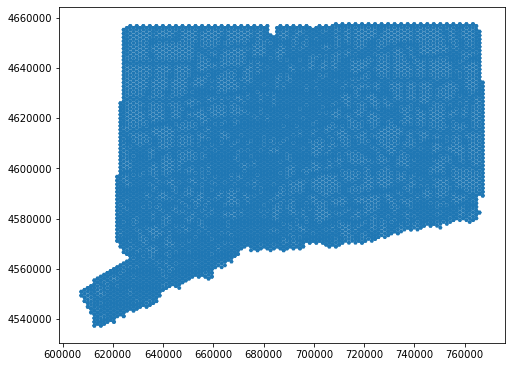

In [6]:
# change to CT grid file
grid_file = gpd.read_file('./CTData/GridFile/ctGrid.shp')
grid_file.plot(figsize=(8,8))

### Load CT Network

In [7]:
# DERRICK: change to CT
#if not os.path.exists("CTData/Connecticut_Network.graphml"):
   # G = osmnx.graph_from_place('Connecticut', network_type='drive') # pulling the drive network the first time will take a while
   # osmnx.save_graphml(G, 'Connecticut_Network.graphml', folder="CTData")
#else:
    #G = osmnx.load_graphml('Connecticut_Network.graphml', folder="CTData", node_type=str)
#osmnx.plot_graph(G, fig_height=10)

## Load CT Buffered Network (to get roads in out of state hospitals)

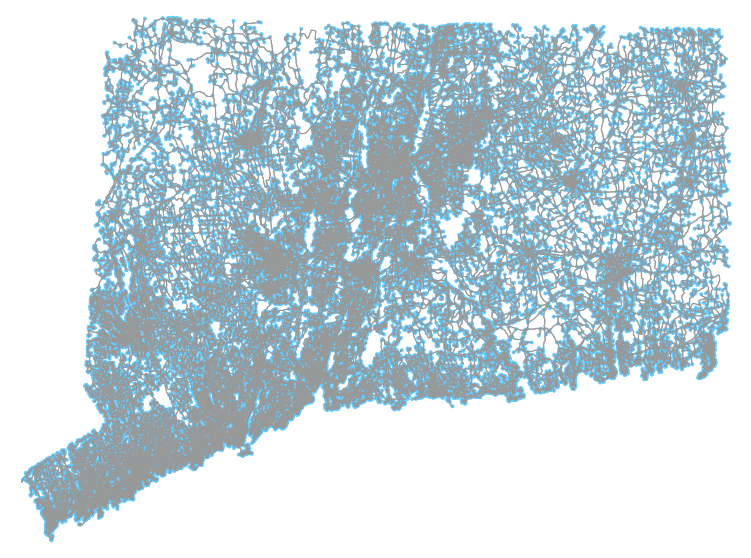

(<Figure size 1303.24x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7efed76d9e90>)

In [8]:
#ct_buff = gpd.read_file('./CTData/NetworkShp/bufferPrj.shp')
if not os.path.exists("CTData/CT_Buffered_Network.graphml"):
    G = osmnx.graph_from_place('Connecticut', buffer_dist=15000, network_type='drive')
    #G = ox.graph_from_bbox(-73.9054017748721,-71.60720220301667,40.8812594400134,42.18560758357975, network_type='drive')
    #G = osmnx.graph_from_polygon(ct_buff, network_type='drive') # pulling the drive network the first time will take a while
    osmnx.save_graphml(G, 'CT_Buffered_Network.graphml', folder="CTData")
else:
    G = osmnx.load_graphml('CT_Buffered_Network.graphml', folder="CTData", node_type=str)
osmnx.plot_graph(G, fig_height=10)

## Functions

In [9]:
# no change
def network_setting(network):
    _nodes_removed = len([n for (n, deg) in network.out_degree() if deg ==0])   #remove 0 outdegree nodes 
    network.remove_nodes_from([n for (n, deg) in network.out_degree() if deg ==0])
    for component in list(nx.strongly_connected_components(network)):   #remove small networks
        if len(component)<10:
            for node in component:
                _nodes_removed+=1
                network.remove_node(node)
    for u, v, k, data in tqdm(G.edges(data=True, keys=True),position=0):  #DERRICK: a bit confused about u, v, k
        if 'maxspeed' in data.keys():
            speed_type = type(data['maxspeed'])
            if (speed_type==str):
                if len(data['maxspeed'].split(','))==2:
                    data['maxspeed']=float(data['maxspeed'].split(',')[0])                  
                elif data['maxspeed']=='signals':
                    data['maxspeed']=35.0 # drive speed setting as 35 miles
                else:
                    data['maxspeed']=float(data['maxspeed'].split()[0])
            else:
                data['maxspeed']=float(data['maxspeed'][0].split()[0])
        else:
            data['maxspeed']= 35.0 #miles
        data['maxspeed_meters'] = data['maxspeed']*26.8223 # convert mile to meter
        data['time'] = float(data['length'])/ data['maxspeed_meters']
    print("Removed {} nodes ({:2.4f}%) from the OSMNX network".format(_nodes_removed, _nodes_removed/float(network.number_of_nodes())))
    print("Number of nodes: {}".format(network.number_of_nodes()))
    print("Number of edges: {}".format(network.number_of_edges()))
    return(network)

## "Helper" Functions

The functions below are needed for our analysis later, let's take a look!

### network_setting

Cleans the OSMNX network to work better with drive-time analysis.

First, we remove all nodes with 0 outdegree because any hospital assigned to such a node would be unreachable from everywhere. Next, we remove small (under 10 node) *strongly connected components* to reduce erroneously small ego-centric networks. Lastly, we ensure that the max speed is set and in the correct units before calculating time.

Args:

* network: OSMNX network for the spatial extent of interest

Returns:

* OSMNX network: cleaned OSMNX network for the spatial extent

### hospital_setting

Finds the nearest OSMNX node for each hospital.

Args:

* hospital: GeoDataFrame of hospitals
* G: OSMNX network

Returns:

* GeoDataFrame of hospitals with info on nearest OSMNX node

In [10]:
# DERRICK: did not change anything
def hospital_setting(hospitals, G):
    hospitals['nearest_osm']=None
    for i in tqdm(hospitals.index, desc="Find the nearest osm from hospitals", position=0):   #loo
        hospitals['nearest_osm'][i] = osmnx.get_nearest_node(G, [hospitals['LATITUDE'][i], hospitals['LONGITUDE'][i]], method='euclidean') # find the nearest node from hospital location
    print ('hospital setting is done')
    return(hospitals)

### pop_centroid

Converts geodata to centroids

Args:

* pop_data: a GeodataFrame
* pop_type: a string, either "pop" for general population or "covid" for COVID-19 case data

Returns:

* GeoDataFrame of centroids with population data

In [11]:
# to estimate the centroids of census tract / county
def pop_centroid (pop_data, pop_type):
    pop_data = pop_data.to_crs({'init': 'epsg:4326'})
    if pop_type =="pop":
        pop_data=pop_data[pop_data['OverFifty']>=0] 
    if pop_type =="covid":
        # DERRICK: change 'cases' to 'Cases'
        pop_data=pop_data[pop_data['Cases']>=0]
    pop_cent = pop_data.centroid # it make the polygon to the point without any other information
    pop_centroid = gpd.GeoDataFrame()
    i = 0
    for point in tqdm(pop_cent, desc='Pop Centroid File Setting', position=0):
        if pop_type== "pop":
            pop = pop_data.iloc[i]['OverFifty']
            # believe 'GEOID' will work
            code = pop_data.iloc[i]['GEOID']
        if pop_type =="covid":
            pop = pop_data.iloc[i]['Cases']
            # change ZCTA5CE10 to objectid
            code = pop_data.iloc[i].OBJECTID
        pop_centroid = pop_centroid.append({'code':code,'pop': pop,'geometry': point}, ignore_index=True)
        i = i+1
        #JOE: somehow this code loses the CRS metadata in conversion to centroids
    pop_centroid.crs = "epsg:4326"
    return(pop_centroid)

### calculate_catchment_area

Calculates a catchment area of things within some distance of a point using a given metric.

Function first creates an ego-centric subgraph on the NetworkX road network starting with the nearest OSM node for the hospital and going out to a given distance as measured by the distance unit. We then calculate the convex hull around the nodes in the ego-centric subgraph and make it a GeoPandas object.

Args:

* G: OSMNX network
* nearest_osm: OSMNX road network node that is closest to the place of interest (hospital)
* distance: the max distance to include in the catchment area
* distance_unit: how we measure distance (used by ego_graph), we always use time

Returns:

* GeoDataFrame the catchment area.

In [12]:
# DERRICK: did not change anything from original
def calculate_catchment_area(G, nearest_osm, distance, distance_unit = "time"):
    road_network = nx.ego_graph(G, nearest_osm, distance, distance=distance_unit) 
    nodes = [Point((data['x'], data['y'])) for node, data in road_network.nodes(data=True)]
    polygon = gpd.GeoSeries(nodes).unary_union.convex_hull ## to create convex hull
    #JOE: Interesting: convex hull may not be the best solution. Maybe a buffer clipped by the convex hull?
    polygon = gpd.GeoDataFrame(gpd.GeoSeries(polygon)) ## change polygon to geopandas
    polygon = polygon.rename(columns={0:'geometry'}).set_geometry('geometry')
    return polygon.copy(deep=True)

### hospital_measure_acc

Measures the effect of a single hospital on the surrounding area. (Uses `calculate_catchment_area`)

Args:

* \_thread\_id: int used to keep track of which thread this is
* hospital: Geopandas dataframe with information on a hospital
* pop_data: Geopandas dataframe with population data
* distances: Distances in time to calculate accessibility for
* weights: how to weight the different travel distances

Returns:

* Tuple containing:
    * Int (\_thread\_id)
    * GeoDataFrame of catchment areas with key stats

In [13]:
def hospital_measure_acc (_thread_id, hospital, pop_data, distances, weights):
    ##distance weight = 1, 0.68, 0.22
    polygons = []
    for distance in distances:
        polygons.append(calculate_catchment_area(G, hospital['nearest_osm'],distance))
    for i in range(1, len(distances)):
        polygons[i] = gpd.overlay(polygons[i], polygons[i-1], how="difference")
        
    num_pops = []
    for j in pop_data.index:
        point = pop_data['geometry'][j]
        for k in range(len(polygons)):
            if len(polygons[i]) > 0: # to exclude the weirdo (convex hull is not polygon)
                if (point.within(polygons[k].iloc[0]["geometry"])):
                    num_pops.append(pop_data['pop'][j]*weights[k])  
    total_pop = sum(num_pops)
    for i in range(len(distances)):
        polygons[i]['time']=distances[i]
        polygons[i]['total_pop']=total_pop
        # DERRICK: add 'BEDS'
        polygons[i]['hospital_beds'] = float(hospital['BEDS'])/polygons[i]['total_pop'] # proportion of # of beds over pops in 10 mins
        polygons[i]['hospital_beds'] = float(hospital['ICU'])/polygons[i]['total_pop'] # proportion of # of beds over pops in 10 mins
        polygons[i].crs = { 'init' : 'epsg:4326'}
        # change UTM zone from 16N 'epsg:32616' to zone 18n 'epsg:32618'
        polygons[i] = polygons[i].to_crs({'init':'epsg:32618'})
    print('\rCatchment for hospital {:4.0f} complete'.format(_thread_id), end="")
    return(_thread_id, [ polygon.copy(deep=True) for polygon in polygons ])

### measure_acc_par

Parallel implementation of accessibility measurement.

Args:

* hospitals: Geodataframe of hospitals
* pop_data: Geodataframe containing population data
* network: OSMNX street network
* distances: list of distances to calculate catchments for
* weights: list of floats to apply to different catchments
* num\_proc: number of processors to use.

Returns:

* Geodataframe of catchments with accessibility statistics calculated

In [14]:
# DERRICK: change nothing
def hospital_acc_unpacker(args):
    return hospital_measure_acc(*args)

#JOE: Add code here to record start time, end time, duration, number of processes... 
# DERRICK: accomplished by printing time where the functions are implemented
def measure_acc_par (hospitals, pop_data, network, distances, weights, num_proc = 4):
    catchments = []
    for distance in distances:
        catchments.append(gpd.GeoDataFrame())
    pool = mp.Pool(processes = num_proc)
    hospital_list = [ hospitals.iloc[i] for i in range(len(hospitals)) ]
    results = pool.map(hospital_acc_unpacker, zip(range(len(hospital_list)), hospital_list, itertools.repeat(pop_data), itertools.repeat(distances), itertools.repeat(weights)))
    pool.close()
    results.sort()
    results = [ r[1] for r in results ]
    for i in range(len(results)):
        for j in range(len(distances)):
            catchments[j] = catchments[j].append(results[i][j], sort=False)
    return catchments

### overlap_calc

Calculates and aggregates accessibility statistics for one catchment on our grid file.

Args:

* \_id: thread ID
* poly: GeoDataFrame representing a catchment area
* grid_file: a GeoDataFrame representing our grids
* weight: the weight to applied for a given catchment
* service_type: the service we are calculating for: ICU beds or ventilators

Returns:

* Tuple containing:
    * thread ID
    * Counter object (dictionary for numbers) with aggregated stats by grid ID number

In [15]:
# DERRICK: did not change anything
from collections import Counter
def overlap_calc(_id, poly, grid_file, weight, service_type):
    value_dict = Counter()
    if type(poly.iloc[0][service_type])!=type(None):           
        value = float(poly[service_type])*weight
        intersect = gpd.overlay(grid_file, poly, how='intersection')
        intersect['overlapped']= intersect.area
        intersect['percent'] = intersect['overlapped']/intersect['area']
        intersect=intersect[intersect['percent']>=0.5]
        intersect_region = intersect['id']
        for intersect_id in intersect_region:
            try:
                value_dict[intersect_id] +=value
            except:
                value_dict[intersect_id] = value
    return(_id, value_dict)

def overlap_calc_unpacker(args):
    return overlap_calc(*args)

## overlapping_function

Calculates how all catchment areas overlap with and affect the accessibility of each grid in our grid file.

Args:

* grid_file: GeoDataFrame of our grid
* catchments: GeoDataFrame of our catchments
* service_type: the kind of care being provided (ICU beds vs. ventilators)
* weights: the weight to apply to each service type
* num\_proc: the number of processors

Returns:

* Geodataframe - grid\_file with calculated stats

In [16]:
# DERRICK: did not change anything
def overlapping_function (grid_file, catchments, service_type, weights, num_proc = 4):
    grid_file[service_type]=0
    pool = mp.Pool(processes = num_proc)
    acc_list = []
    for i in range(len(catchments)):
        acc_list.extend([ catchments[i][j:j+1] for j in range(len(catchments[i])) ])
    acc_weights = []
    for i in range(len(catchments)):
        acc_weights.extend( [weights[i]]*len(catchments[i]) )
    results = pool.map(overlap_calc_unpacker, zip(range(len(acc_list)), acc_list, itertools.repeat(grid_file), acc_weights, itertools.repeat(service_type)))
    pool.close()
    results.sort()
    results = [ r[1] for r in results ]
    service_values = results[0]
    for result in results[1:]:
        service_values+=result
    for intersect_id, value in service_values.items():
        grid_file.loc[grid_file['id']==intersect_id, service_type] += value
    return(grid_file)

### normalization

Normalizes our result (Geodataframe) for a given resource (res).

In [17]:
# DERRICK: did not change anything
def normalization (result, res):
    result[res]=(result[res]-min(result[res]))/(max(result[res])-min(result[res]))
    return result

# file_import

Imports all files we need to run our code and pulls the Illinois network from OSMNX if it is not present (will take a while). 

**NOTE:** even if we calculate accessibility for just Chicago, we want to use the Illinois network (or at least we should not use the Chicago network) because using the Chicago network will result in hospitals near but outside of Chicago having an infinite distance (unreachable because roads do not extend past Chicago).

Args:

* pop_type: population type, either "pop" for general population or "covid" for COVID-19 cases
* region: the region to use for our hospital and grid file ("Chicago" or "Illinois")

Returns:

* G: OSMNX network
* hospitals: Geodataframe of hospitals
* grid_file: Geodataframe of grids
* pop_data: Geodataframe of population

In [18]:
def file_import (pop_type, region):
    # DERRICK: change to CT and change file path to CTDAta
    if not os.path.exists("CTData/CT_Buffered_Network.graphml"):
        G = osmnx.graph_from_place('Connecticut', network_type='drive') # pulling the drive network the first time will take a while
        osmnx.save_graphml(G, 'CT_Buffered_Network.graphml', folder="CTData")
    else:
        G = osmnx.load_graphml('CT_Buffered_Network.graphml', folder="CTData", node_type=str)
    # change to CT Hospitals
    hospitals = gpd.read_file('./CTData/HospitalData/hospitals.shp'.format(region))
    # change to ctGrid -- possibility for later -- to make scalable grids basde on hospital regions
    grid_file = gpd.read_file('./CTData/GridFile/ctGrid.shp'.format(region))
    if pop_type=="pop":
        pop_data = gpd.read_file('./CTData/PopData/csTracts.shp'.format(region))
    if pop_type=="covid":
        pop_data = gpd.read_file('./CTData/PopData/covidTown.shp'.format(region))
    return G, hospitals, grid_file, pop_data

In [19]:
def output_map(output_grid, base_map, hospitals, resource):
    ax=output_grid.plot(column=resource, cmap='OrRd',figsize=(18,12), legend=True, zorder=1)
    base_map.plot(ax=ax, facecolor="none", edgecolor='gray', lw=0.1)
    #ax.scatter(hospitals.LONGITUDE, hospitals.LATITUDE, zorder=1, c='black', s=8)
    hospitals.plot(ax=ax, markersize=10, zorder=1, c='blue')
    #JOE: changed code to plot hospitals with geometry rather than X and Y attributes, so that points may be projected

### Run the model

Below you can customize the input of the model:

* Processor - the number of processors to use
* Region - the spatial extent of the measure
* Population - the population to calculate the measure for
* Resource - the hospital resource of interest

In [20]:
import ipywidgets
from IPython.display import display

processor_dropdown = ipywidgets.Dropdown( options=[("1", 1), ("2", 2), ("3", 3), ("4", 4)],
    value = 1, description = "Processor: ")

place_dropdown = ipywidgets.Dropdown( options=[("Connecticut", "Connecticut")],
    value = "Connecticut", description = "Region: ")

population_dropdown = ipywidgets.Dropdown( options=[("Population at Risk", "pop"), ("COVID-19 Patients", "covid") ],
    value = "pop", description = "Population: ")

resource_dropdown = ipywidgets.Dropdown( options=[("All Beds", "hospital_beds"), ("ICU Beds", "hospital_ICU")],
    value = "hospital_beds", description = "Resource: ")
display(processor_dropdown,place_dropdown,population_dropdown,resource_dropdown)

Dropdown(description='Processor: ', options=(('1', 1), ('2', 2), ('3', 3), ('4', 4)), value=1)

Dropdown(description='Region: ', options=(('Connecticut', 'Connecticut'),), value='Connecticut')

Dropdown(description='Population: ', options=(('Population at Risk', 'pop'), ('COVID-19 Patients', 'covid')), …

Dropdown(description='Resource: ', options=(('All Beds', 'hospital_beds'), ('ICU Beds', 'hospital_ICU')), valu…

In [26]:
G, hospitals, grid_file, pop_data = file_import (population_dropdown.value, place_dropdown.value)
G = network_setting (G)
pop_data = pop_centroid(pop_data, population_dropdown.value)
hospitals = hospital_setting(hospitals, G)
distances=[10,20,30] # distances in travel time
weights=[1.0, 0.68, 0.22] # weights where weights[0] is applied to distances[0]
resources = ["hospital_beds"] # resources

100%|██████████| 330436/330436 [00:00<00:00, 486032.21it/s]


Removed 213 nodes (0.0016%) from the OSMNX network
Number of nodes: 131312


Pop Centroid File Setting:   0%|          | 0/172 [00:00<?, ?it/s]

Number of edges: 330436


Find the nearest osm from hospitals: 100%|██████████| 41/41 [00:16<00:00,  2.51it/s]

hospital setting is done


In [22]:
# DERRICK: Add Code to PRINT processing time 
start_time = time.time()
catchments = measure_acc_par(hospitals, pop_data, G, distances, weights, num_proc=processor_dropdown.value)
print("--- %s seconds ---" % (time.time() - start_time))

Catchment for hospital   40 complete--- 203.2328176498413 seconds ---


In [23]:
# DERRICK: Add Code to PRINT processing time (seems)
start_time = time.time()
for j in range(len(catchments)):
    catchments[j] = catchments[j][catchments[j][resource_dropdown.value]!=float('inf')]
result=overlapping_function(grid_file, catchments, resource_dropdown.value, weights, num_proc=processor_dropdown.value)
print("--- %s seconds ---" % (time.time() - start_time))

--- 205.82893681526184 seconds ---


In [24]:
result = normalization (result, resource_dropdown.value)

### Visualization & Conclusion

The black dots represent hospitals. People living in the darker-colored regions are more accessible to the hospitals than those living in the lighter-colored regions. To cope with this health inequality issue, policy makers need to consider about placing more hospitals in the ligher-colored regions. This can also be applicable to COVID-19. 

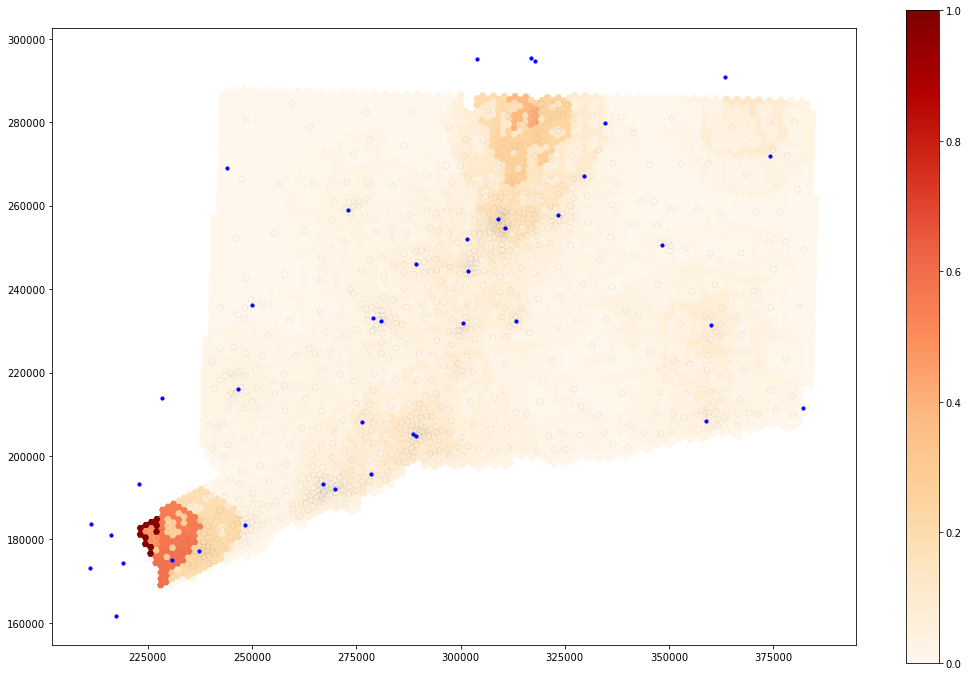

In [25]:
# DERRICK: Add code to transform to CT State Plane
result = result.to_crs({'init': 'epsg:6433'})
hospitals=hospitals.to_crs(epsg=6433)
pop_data=pop_data.to_crs(epsg=6433)
output_map(result, pop_data, hospitals, resource_dropdown.value)
# DERRICK: add code to save the output plot
# uncomment the below line if you want to save the output (rename)
plt.savefig("./CTData/Result/CovidCaseDRAFT1.png")